In [1]:
import numpy as np
import pandas as pd
import random as r
import datetime as dt
from matplotlib import pyplot as plt
import functools as ft
from operator import itemgetter

In [2]:
# Timing Decorator
def time_it(func):
    def wrapped_func(self):
        start_time = dt.datetime.now()
        print("Start time: {}".format(start_time))
        func(self)
        end_time = dt.datetime.now()
        print("End time: {}".format(end_time))
        print("Time taken: {}\n".format(end_time - start_time))
    return wrapped_func

In [71]:
class SA():
    def __init__(self, 
                 time_mtrx, 
                 actual_list, 
                 expected_list, 
                 station_capacity, 
                 truck_capacity, 
                 time_limit = 1000,
                 temp_schedule=100, 
                 K=100, 
                 alpha=0.99, 
                 iter_max=1000, 
                 temp=100, 
                 tolerance=500, 
                 punish_do_nothing=True, do_nothing_punishment = 1000, track_progress=True, verbose=True, debug=False):
        
        # depot is assumed to be the first stop  
        # SA algorithm hyper-parameters
        self.K = K
        self.temp_schedule = temp_schedule
        self.alpha = alpha
        self.iter_max = iter_max
        self.temp = temp
        self.tolerance = tolerance
        self.verbose = verbose
        self.punish_do_nothing = punish_do_nothing
        self.do_nothing_punishment = do_nothing_punishment
        self.track_progress = track_progress
        if self.track_progress: self.progress = []
        self.debug = debug
        
        # Problem constants
        self.ind_to_stop, self.actual_list, self.expected_list, self.time_mtrx, self.station_capacity \
            = self.preprocess_constants(actual_list, expected_list, time_mtrx, station_capacity)
        self.actual_list_raw = actual_list
        self.expected_list_raw = expected_list
        self.station_capacity_raw = station_capacity
        self.C = truck_capacity
        self.time_limit = time_limit
        
        self.N = len(self.actual_list)
        output_action = lambda act, exp: 1 if act < exp else -1 if act > exp else 0
        
        # p_action: pickup(-1) or dropoff(1)
        self.p_action = [output_action(x[0], x[1]) for x in zip(self.actual_list, self.expected_list)]
        
        
        self.diff = list(np.array(self.expected_list) - np.array(self.actual_list))
        
        # Sanity check on problem definition
        if any([x[0] > x[1] for x in zip(self.actual_list, self.station_capacity)]):
            raise ProblemDefinitionError("Actual # bikes at stations exceeds capacity.")
        elif any([x[0] > x[1] for x in zip(self.expected_list, self.station_capacity)]):
            raise ProblemDefinitionError("Expected # bikes at stations exceeds capacity.")
        elif all([x == 0 for x in self.diff]):
            raise ProblemDefinitionError("No re-distribution is needed.")
        elif all([x >= 0 for x in self.diff]):
            raise ProblemDefinitionError("Net bike deficit.")
    
    
    # Remove stops w/o the need of rebalancing
    def preprocess_constants(self, actual_list, expected_list, time_mtrx, station_capacity):
        ind_to_opt = [0] + list(np.where(np.array(actual_list) != np.array(expected_list))[0])
        ind_to_stop = list(itemgetter(*ind_to_opt)(list(range(len(actual_list)))))
        actual_adj = list(itemgetter(*ind_to_opt)(actual_list))
        expected_adj = list(itemgetter(*ind_to_opt)(expected_list))
        time_mtrx_adj = time_mtrx[ind_to_opt,:][:,ind_to_opt]
        station_cap_adj = list(itemgetter(*ind_to_opt)(station_capacity))
        return ind_to_stop, actual_adj, expected_adj, time_mtrx_adj, station_cap_adj
    
    
    # Calculate total time of the route
    def cost(self, seq):
        segments = [seq[i:i+2] for i in range(len(seq)-1)]
        time_sum = sum([self.time_mtrx[seg[0], seg[1]] for seg in segments])
        return time_sum
    
    
    def gen_actions(self, seq):
        '''
        Generate the complete action of one iteration
        '''
        
        actions = [0]
        truck_inv = [0]
        station_inv = self.actual_list.copy()
        
        for s in seq[1:-1]:
            if self.diff[s] < 0: # pick up, to_pickup < 0
                # to_pickup 是负数，
                to_pickup = max(self.diff[s], truck_inv[-1]-self.C) 
                actions += [to_pickup]
                truck_inv += [truck_inv[-1] - to_pickup]
                station_inv[s] += to_pickup
            elif self.diff[s] > 0:  # drop off
                to_dropoff = min(self.diff[s], truck_inv[-1])
                actions += [to_dropoff]
                truck_inv += [truck_inv[-1] - to_dropoff]
                station_inv[s] += to_dropoff
        
        actions += [0]
        truck_inv += [truck_inv[-1]]
        
        # station_inv 每次只变化一个？
        
        return actions, truck_inv, station_inv
    
    
    def objective(self, seq):
        actions, _, station_inv = self.gen_actions(seq)
        
        # Q1: objective function <0 的sum两者取差
        obj = abs(np.array(station_inv) - np.array(self.expected_list)).sum()
        
        if self.punish_do_nothing:
            do_nothing = any([x == 0 for x in actions[1:-1]])
            # Q4: Maximize objective function -=?
            obj += do_nothing * self.do_nothing_punishment
        
        return obj
        
    
    def gen_init_seq(self):
        # get a list of stations that needs to be picked up
        need_pickup = np.where(np.array(self.p_action) == -1)[0]
        return [0] + [r.choice(need_pickup)] + [0]
    
    
    def permute_seq(self, seq, perm):
        
        seq_new = seq.copy()
        
        if perm == "insert":
            stops_to_add = list(set(range(self.N)).difference(set(seq)))
            pos_to_add = range(1,len(seq))
            pos, stop = r.choice(pos_to_add), r.choice(stops_to_add)
            seq_new = seq_new[:pos] + [stop] + seq_new[pos:]
        elif perm == "remove":
            stops_to_remove = list(set(seq).difference({0}))
            pos_to_remove = range(1, len(seq)-1)
            # Q: 这个部分好像和stop没有关系吧？只randomize position应该可以
            pos, stop = r.choice(pos_to_remove), r.choice(stops_to_remove)
            seq_new = seq_new[:pos] + seq_new[pos+1:]
        elif perm == "swap":
            pos_to_swap = range(1, len(seq)-1)
            pos1, pos2 = sorted(r.sample(pos_to_swap, 2))
            seq_new = seq_new[:pos1] + [seq_new[pos2]] + seq_new[pos1+1:pos2] + [seq_new[pos1]] + seq_new[pos2+1:]
        elif perm == "revert":
            pos_to_revert = range(1, len(seq_new)-1)
            pos1, pos2 = sorted(r.sample(pos_to_revert, 2))
            seq_new = seq_new[:pos1] + seq_new[pos1:pos2+1][::-1] + seq_new[pos2+1:]
        else:
            raise ValueError("Illegal permutation. 4 legal permutations include 'insert', 'remove', 'swap', and 'revert'.")
        
        return seq_new
    
    
    def gen_new_seq(self, seq):
        
        # Decide on candidate permutations to perform
        # 跑不完的不去penalize么？
        if self.cost(seq) > self.time_limit:
            candidate_perm = ['remove', 'swap', 'revert']
        # 新generate的seq会不会出现跑不完的情况？
        elif len(seq) - 1 == self.N:
            candidate_perm = ['swap', 'revert']
        elif len(seq)-2 == 1:
            candidate_perm = ['insert']
        else:
            candidate_perm = ['insert', 'remove', 'swap', 'revert']
        
        # Check constraints
        keep_searching = True
        
        while keep_searching:
            rand_perm = r.choice(candidate_perm)
            # 改action
            seq_new = self.permute_seq(seq, rand_perm)
            if self.cost(seq_new) < self.time_limit:
                keep_searching = False
        
        return seq_new
    
    @time_it
    def simulated_annealing(self):
        
        # only choose initial station for pickup* 
        seq_curr = self.gen_init_seq()
        
        obj_curr = self.objective(seq_curr)
        seq_best = seq_curr.copy()
        obj_best = obj_curr
        i = 0
        i_tol = 0
        
        # start iteration from the first position 
        while (i < self.iter_max) & (i_tol < self.tolerance):
            
            seq_new = self.gen_new_seq(seq_curr)
            obj_curr = self.objective(seq_curr)
            obj_new = self.objective(seq_new)
            
            if obj_curr <= obj_new:# maximize？
                seq_curr = seq_new
                obj_curr = obj_new
            elif r.uniform(0, 1) < np.exp(-(obj_new - obj_curr) / (self.K + self.temp)):
                seq_curr = seq_new
                obj_curr = obj_new
                
            if obj_curr < obj_best:
                # Q2: obj_curr > obj_best?
                obj_best = obj_curr
                seq_best = seq_curr
                i_tol = 0
            else:
                i_tol += 1
            
            if (i % self.temp_schedule == 0) & (i > 0):
                self.temp *= self.alpha
                
            i += 1
            if (self.verbose == True) & ((i + 1) % 2000 == 0):
                print('{} iterations. Best obj: {}. Temperature : {}'.format(i+1, obj_best, self.temp))
            
            if self.track_progress:
                self.progress += [{'iter': i, 'seq_curr': seq_curr, 'obj_curr': obj_curr,
                                   'seq_best': seq_best, 'obj_best': obj_best,
                                   'temp': self.temp}]
        
            if self.debug:
                print("Round - {}, Temp - {}, Route - {}, Obj - {}".format(i, self.temp, seq_curr, obj_curr))
        
        # Record
        self.route = seq_best
        self.redist_obj = obj_best
        self.actions, self.truck_inventory, self.station_inventory = self.gen_actions(self.route)
        if self.track_progress:
            self.progress = pd.DataFrame.from_dict(self.progress)
    
    
    def print_solution(self):
        print("Iterations: {}.".format(self.progress.shape[0]))
        action_type = ['+' + str(x) if x > 0 else str(x) for x in self.actions]
        action_seq = ' --> '.join(['0'] + [str(x) + ' (' + y + ')' for x, y in zip(self.route, action_type)][1:-1] + ['0'])
        print("Route: {}".format(action_seq))
        print("Objective(unsatisfied customer): {}".format(self.redist_obj))
        print("Time: {}".format(self.cost(self.route)))
        
        print("\nROUTE")
        sol = {"stop": self.route,
               "action": self.actions,
               "truck_inv": self.truck_inventory,
               "station_inv": [self.station_inventory[x] for x in self.route]
               }
        print(pd.DataFrame.from_dict(sol))
        
        print("\nSTATION INVENTORY")
        redist = [self.station_inventory[self.ind_to_stop.index(x)] if x in self.ind_to_stop \
                  else self.actual_list_raw[x] for x in range(len(self.actual_list_raw))]
        inv = {'actual': self.actual_list_raw,
               'expected': self.expected_list_raw,
               'redist': redist,
               'diff': abs(np.array(redist) - np.array(self.expected_list_raw))
               }
        print(pd.DataFrame.from_dict(inv))
        

    
    def plot_convergence(self, plot_obj_curr=False):
    
        fig, ax1 = plt.subplots()
        ax2 = ax1.twinx()
        
        if plot_obj_curr:
            ln1 = ax1.plot(self.progress['obj_curr'].values, color = 'blue')
        ln2 = ax1.plot(self.progress['obj_best'].values, color = 'green')
        ln3 = ax2.plot(self.progress['temp'].values, color = 'lightgrey', linestyle='dashed')
        
        if plot_obj_curr:
            ax1.legend(ln1 + ln2 + ln3, ['Objective Local', 'Objective Best', 'Temperature'])
        else:
            ax1.legend(ln2 + ln3, ['Objective Local', 'Objective Best', 'Temperature'])
                
        plt.title("SA Convergence")
        plt.xlabel("Iterations")
        ax1.set_ylabel("Reward")
        ax2.set_ylabel("Temperature")

In [72]:
time_mtrx = np.array([0, 3, 12, 4,
                      3, 0, 8, 9,
                      12, 8, 0, 10,
                      4, 9, 10, 0]).reshape(4,4)
time_limit = 100
truck_capacity = 10
actual_list = [0, 5, 3, 4]
expected_list = [0, 2, 7, 3]
station_capacity = [0, 8, 8, 8]
debug = False

In [73]:
opt = SA(time_mtrx = time_mtrx,
         time_limit = time_limit,
         actual_list = actual_list, 
         expected_list = expected_list,
         station_capacity = station_capacity,
         truck_capacity = truck_capacity,
         debug = debug)

In [74]:
opt.simulated_annealing()  # Run the optimizatino algorithm

Start time: 2020-11-18 10:39:55.691863
End time: 2020-11-18 10:39:55.740967
Time taken: 0:00:00.049104



In [75]:
opt.print_solution()  # Print report

Iterations: 510.
Route: 0 --> 3 (-1) --> 1 (-3) --> 2 (+4) --> 0
Objective(unsatisfied customer): 0
Time: 33

ROUTE
   stop  action  truck_inv  station_inv
0     0       0          0            0
1     3      -1          1            3
2     1      -3          4            2
3     2       4          0            7
4     0       0          0            0

STATION INVENTORY
   actual  expected  redist  diff
0       0         0       0     0
1       5         2       2     0
2       3         7       7     0
3       4         3       3     0


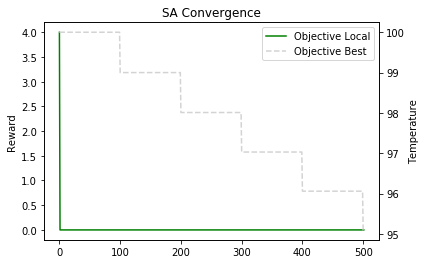

In [20]:
opt.plot_convergence()